## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.utils import cov_to_dist
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
plt.rcParams['axes.axisbelow'] = True
rng = np.random.default_rng(2022)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [26]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

def get_resmat(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if mode=='sampled':
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
    else:
        neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
            # finds the neighboring deme that has samples
        neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

        R1d = -2*obj.Lpinv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Lpinv[lrn[0][1],lrn[0][1]]
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

        # apply this formula only to neighboring sampled demes
        for n in neighs:
            # convert back to appropriate indexing excluding the unsampled demes
            s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
            # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
            resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
            resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([lrn[0][0]])])[:sp_graph.n_observed_nodes]
        # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
            Ri1 = -2*obj.Lpinv[i,lrn[0][0]] + obj.Lpinv[i,i] + obj.Lpinv[lrn[0][0],lrn[0][0]]
            # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
            # should there be a (1+c)q_d here?
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c*qprox
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
  
    return resmat

def get_resmat_mult(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if mode=='sampled':
        for ic, ct in enumerate(c):
            resmat[lrn[ic][0],lrn[ic][1]] = (0.5*ct**2-1.5*ct+1)*Rmat[lrn[ic][0],lrn[ic][1]] + (1+ct)/sp_graph.q[lrn[ic][0]] + (1-ct)/sp_graph.q[lrn[ic][1]]
            resmat[lrn[ic][1],lrn[ic][0]] = resmat[lrn[ic][0],lrn[ic][1]]

            ## id
            for i in set(range(sp_graph.n_observed_nodes))-set([lrn[ic][0],lrn[ic][1]]):
                resmat[i,lrn[ic][1]] = (1-ct)*(Rmat[i,lrn[ic][1]]) + ct*Rmat[i,lrn[ic][0]] + 0.5*(ct**2-ct)*Rmat[lrn[ic][0],lrn[ic][1]] + 1/sp_graph.q[i] + (1-ct)/sp_graph.q[lrn[ic][1]] + ct/sp_graph.q[lrn[ic][0]]
                resmat[lrn[ic][1],i] = resmat[i,lrn[ic][1]]
    else:
        neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
            # finds the neighboring deme that has samples
        neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

        R1d = -2*obj.Lpinv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Lpinv[lrn[0][1],lrn[0][1]]
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

        # apply this formula only to neighboring sampled demes
        for n in neighs:
            # convert back to appropriate indexing excluding the unsampled demes
            s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
            # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
            resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
            resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([lrn[0][0]])])[:sp_graph.n_observed_nodes]
        # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
            Ri1 = -2*obj.Lpinv[i,lrn[0][0]] + obj.Lpinv[i,i] + obj.Lpinv[lrn[0][0],lrn[0][0]]
            # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
            # should there be a (1+c)q_d here?
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c*qprox
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
  
    return resmat

In [1356]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T)#, np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [3]:
def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T); resmat[np.diag_indices(sp_graph.n_observed_nodes)] = 0 #- 2*sp_graph.q_inv_diag

    # need to compute pseudo-inverse of L_{d x d}
    Lpinv = np.linalg.pinv(sp_graph.L.todense())  

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [10]:
# obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
# obj.neg_log_lik_c(0,{'lre':[(9,0)],'mode':'sampled'}), obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.q),sp_graph.c,sp_graph.t],{'lre':[(9,0)]})
# obj.neg_log_lik(), obj.neg_log_lik_c_t([0.55,0.00],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.55,{'lre':[(22,57)],'mode':'sampled'}),
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead') #14891
# plt.imshow(obj.Linv-obj_nomu.Linv,cmap='RdBu'); plt.colorbar()
# plt.plot(1/sp_graph.q, 1/sp_graph_nomu.q, 'ko'); plt.axline((0,0),slope=1)
# plt.plot(sp_graph.w, sp_graph_nomu.w, 'ko'); plt.axline((0,0),slope=1)
# obj_nomu.extract_outliers(pthresh=0.01)
# plt.plot(sp_graph.w, np.exp(newres[0][:sp_graph.size()]),'ko')
# newres[1], obj.neg_log_lik_c_t([0.5,0.0],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'})
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.3,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.5,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.7,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)]); 

In [624]:
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20); plt.show()
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., option='bothct', long_range_edges=[(23,56)])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),obj.sp_graph.c],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c_t,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5,1e-2],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e7,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)]+[(0,0.2)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-2]), newres[0][-2:])
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.26,0.00],args=({'lre':[(22,57)]}),method='Nelder-Mead',bounds=[(0,1),(0,0.03)]), sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'}),method='L-BFGS-B',bounds=[(0,1)]), newres[1], obj.neg_log_lik_c_t([0.5,0.001],{'lre':[(22,57)]}),obj.neg_log_lik_c(0.09,{'lre':[(22,57)],'mode':'sampled'}) # 13401
# sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'})), sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.22,1e-4],args=({'lre':[(22,57)]}),method='L-BFGS-B',bounds=[(0,1),(0,0.2)])
# obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.29],{'lre':[(22,57)]})
# obj.joint_neg_log_lik_c_t(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.6,0.01],{'lre':[(22,57)]}) #
# -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat_hao @ C.T)

Text(0, 0.5, 'empirical distance')

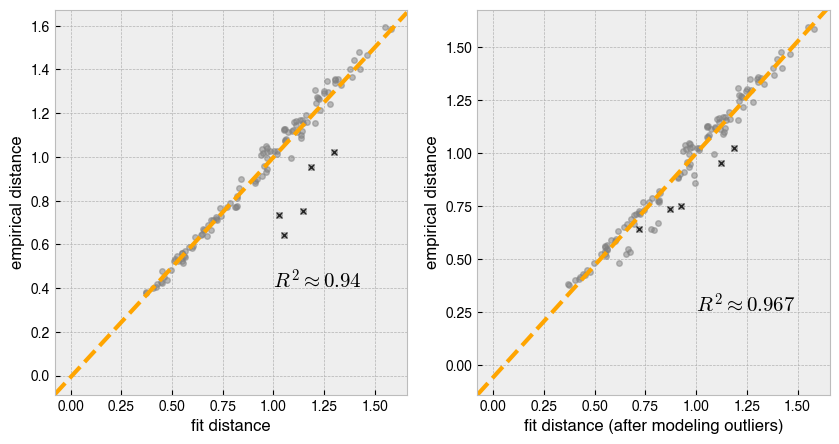

In [59]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1e-2, barrier_w=1e-2, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=6, n_samples_per_node=15)
# gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=800, n_print=700, long_range_nodes=[(22,57),(10,77),(19,63)], admixture_props=[0.5,0.3,0.8], time_of_adm=[1e-6,1e-4,1e-4], n_e=10, dump=False)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# %time sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); #oldw = sp_graph.w; olds2 = sp_graph.s2
# df = obj.extract_outliers(0.001,verbose=False)
# plt.plot(oldw,np.exp(newres[0][:sp_graph.size()]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.xlabel(r'$\hat w$ before joint optimization'); plt.ylabel(r'$\hat w$ after')
# plt.plot(olds2,np.exp(newres[0][sp_graph.size():-2]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.plot(olds2[57],np.exp(newres[0][sp_graph.size():-2])[57],'r*'); plt.xlabel(r'$\hat \sigma^2$ before joint optimization'); plt.ylabel(r'$\hat \sigma^2$ after')
# np.exp(newres[0][sp_graph.size():-1])
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, abs_max=0.25,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# sp_graph.fit(lamb=3., optimize_q=None, option='onlyc', long_range_edges=[(23,56)]); sp_graph.c
# sp_graph.q

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
# pvals = sp.stats.norm.cdf(np.log(emp_dist)-np.log(fit_dist)-np.mean(np.log(emp_dist)-np.log(fit_dist)), 0, np.std(np.log(emp_dist)-np.log(fit_dist)))
med = np.median(np.log(emp_dist)-np.log(fit_dist))
mad = 1.4826*np.median(np.abs(np.log(emp_dist)-np.log(fit_dist) - med))
mvals = (np.log(emp_dist)-np.log(fit_dist) - med)/mad
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.plot(fit_dist[mvals<-3], emp_dist[mvals<-3], 'r*', alpha=0.8, markersize=4)
plt.text(1, 0.4, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,3)), fontsize=15); plt.xlabel('fit distance'); plt.ylabel('empirical distance'); 

plt.subplot(122)
# resmat = get_resmat_mult([0.5,1,0.3], sp_graph, obj, [(22,57),(19,63),(10,77)], 'sampled')
resmat = get_resmat(0.41, sp_graph, obj, [(27,9)], 'unsampled')
res_dist = np.array(cov_to_dist(-0.5*resmat)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)])[0]
X = sm.add_constant(res_dist.T)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
plt.plot(res_dist.T, emp_dist, 'o', color='k', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.plot(res_dist.T[mvals<-3], emp_dist[mvals<-3], 'r*', alpha=0.8, markersize=4)
plt.text(1, 0.25, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,3)), fontsize=15); plt.xlabel('fit distance (after modeling outliers)'); plt.ylabel('empirical distance')

# lle, te = get_best_lre(sp_graph, gen_test_2, coord_def, grid_def, edge_def, k=2, top=5, nchoose=100, option='hard')
# defw = sp_graph.w; defq = sp_graph.q
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint', long_range_edges=[(23,56)], c=0.2); #sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(23,56)], c=0.2) 
# jtw = sp_graph.w; jtq = sp_graph.q
# grjt = obj.grad_obj
# plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$'); plt.show()
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

In [216]:
# df['log-lik'].sort_values(ascending=False)[:int(0.1*len(df))]
# for it, row in df.loc[topidx].iterrows():
# joint_contour_df = df.loc[topidx]
# joint_contour_df['log-lik'] - joint_df
# sp.stats.chi2.sf(2*joint_df.loc[topidx-1]['log-lik'].values+2*840,1)
# %timeit eigval, eigvec = np.linalg.eig(sp_graph.L.T.todense()); Dpinv = np.diag([1/e if e > 1e-6 else 0 for e in eigval]); minv = eigvec @ Dpinv @ eigvec.T
# %timeit np.linalg.pinv(sp_graph.L.todense())
# %timeit sp.linalg.pinvh(sp_graph.L.todense())
# plt.imshow(minv - obj.Lpinv); plt.colorbar()
# , joint_df.loc[topidx-1], joint_contour_df

5.2 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [549]:
# sampnodes = np.sort(np.unique(np.random.choice(97,16,replace=False).tolist()+[51,44])).tolist()#[2,14,18,25,31,44,46,51,57,66,74,77]
# sampnodes = [2,4,10,12,14,15,21,28,30,36,44,60,63,66,80,83,89]
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=500, long_range_nodes=[(51,44)], admixture_props=[0.5], n_e=np.geomspace(1e1,1e4,96), time_of_adm=[1e-7])
# coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = gen_test_80[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
# sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
# sp_graph.fit(lamb=.5,optimize_q='1-dim',lamb_q=1.)
# obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# sp_graph.sequential_fit(lamb=0.5,lamb_q=1.,optimize_q='1-dim',top=5,search_area='radius',opts=3)
# top = obj.extract_outliers(0.25, verbose=True); #obj.inv(); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense()); obj.grad(reg=False)
# df = obj.calc_contour(destid=44,search_area='radius',sourceid=49,opts=1,exclude_boundary=False)
# [list(sp_graph.neighbors(n)) for n in [df['(source, dest.)'].iloc[i][0] for i in range(len(df))]], [df['(source, dest.)'].iloc[i][0] for i in range(len(df))]
# sampnodes = list(np.arange(0,97)[::2])#+[63]
# sampnodes = [2,18,25,31,44,46,57,62,74]
# sampnodes = [2,4,10,12,14,15,20,28,30,36,44,51,57,60,63,66,80,83,86,89]
# sampnodes = np.sort(np.unique(np.random.choice(97,20,replace=False).tolist()+[51,44])).tolist()
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# sampnodes = [2,14,18,25,31,44,46,57,62,66]
# np.array(ss)[np.array(sampnodes)]
ss = [20 if i in list(range(1,12)[::2])+list(range(12,24)[::2])+list(np.arange(1,12)[::2]+24)+
      list(np.arange(12,24)[::2]+24)+list(np.arange(1,12)[::2]+48)+list(np.arange(12,24)[::2]+48)+
      list(np.arange(1,12)[::2]+72)+list(np.arange(12,24)[::2]+72) else 0 for i in range(96)]
# ss = [20 if i in np.sort(list(range(96)[::2])+[51]).tolist() else 0 for i in range(96)]
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=8, n_samples_per_node=10, option=2, ss=ss)
# foo = lambda c: [simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=800, long_range_nodes=[(51,44)], admixture_props=[c], n_e=100, time_of_adm=[1e-7])]
# sims = Parallel(n_jobs=4)(delayed(foo)(0.5) for _ in range(3))
# sims = []
# for i in range(16):
#     sims.append(foo(0.5))
# sp_graph.genotypes.shape
# coord_def.shape, coord.shape
# df = sp_graph.calc_contour(destid=44,search_area='all',exclude_boundary=False)
# df.iloc[5:60]

## Function to simulate under the two different schemes (in Parallel)

In [548]:
## writing to disc the simulations and results
# import pickle 
## results.to_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp_c5.csv")
## with open("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/dense_samp_sims_c25.pkl", 'wb') as fp:
##     pickle.dump(sims25, fp)

[array([[0, 0, 2, ..., 2, 0, 0],
        [0, 0, 2, ..., 2, 0, 0],
        [0, 0, 2, ..., 2, 1, 0],
        ...,
        [0, 1, 0, ..., 2, 0, 0],
        [1, 1, 1, ..., 2, 0, 0],
        [0, 1, 2, ..., 2, 0, 0]], dtype=int32)]

In [556]:
# def sim_var_sparse(nsnps, c, sparsity):
#     sampnodes = np.sort(np.unique(np.random.choice(97,sparsity,replace=False).tolist()+[51,44])).tolist()#[2,14,18,25,31,44,46,51,57,66,74,77]
#     ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
#     n_e = 10**(1+np.random.random(96)*3)
#     gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=nsnps, n_print=int(0.8*nsnps), long_range_nodes=[(51,44)], admixture_props=[c], n_e=n_e, time_of_adm=[1e-7])

#     return [gen_test_80, ss, n_e, coord_def]   
    
# _, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                        barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# sims = Parallel(n_jobs=16)(delayed(sim_var_sparse)(1000,0.,16) for _ in range(16))
# sims = Parallel(n_jobs=16)(delayed(sim_var_alternate)(1000,0.5) for _ in range(16))
# top = obj.extract_outliers(0.25)

# with open('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/dense_samp_sims.pkl', 'rb') as fp:
#     sims = pickle.load(fp)
# results = pd.read_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp.csv", index_col=0)

rep = 6
# coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = sims25[rep][0][list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
# gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

sp_graph = SpatialGraph(sims[rep][0], coord_def, grid_def, edge_def)
sp_graph.fit(lamb=.3,optimize_q='n-dim',lamb_q=1., verbose=False); 

# obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)

# lamb_grid = np.geomspace(1e-2,1e2,10,endpoint=True)[::-1]; lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
# cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=10, factr=1e10, inner_verbose=False, outer_verbose=False)
# mean_cv_err = np.nanmean(cv_err, axis=0)

# sp_graph.fit(lamb=.3,lamb_q=1.,optimize_q='n-dim',long_range_edges=[(51,44)],option='onlyc'); print(sp_graph.c)
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=3, abs_max=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=40, sample_pt_color="black", cbar_font_size=20, cbar_ticklabelsize=16)
# v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()
# top = sp_graph.extract_outliers(0.25)
# sp_graph.extract_outliers(fdr=0.2)
df = sp_graph.calc_contour(destid=44,exclude_boundary=False)
# df.iloc[45:60]

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 89 demes in the graph...25%...

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


50%...75%...done!


## Estimation & storing of relevant results (ALL BELLS & WHISTLES)

In [18]:
# results = pd.DataFrame(index=range(16), columns=['ss','n_e','lamb_cv','lamb_q_cv','baselinew','baselines2','outliers','baselinell',
#                                                 'mle_point_ll','mle_point_id','mle_point_c','mle_point_loc','all_point_ll','all_point_c',
#                                                 'mle_joint_ll','mle_joint_id','mle_joint_c','mle_joint_loc','all_joint_ll','all_joint_c'])
for rep in range(16):
    ## removing the source from the grid
    coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    results.loc[rep,'ss'] = ss
    results.loc[rep,'n_e'] = sims[rep][2]

    ## creating the object
    sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
    
    ## CV scheme (10-fold and LOO gives similar results for these sims)
    lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]; lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
    cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=10, factr=1e10, inner_verbose=False, outer_verbose=False)
    mean_cv_err = np.nanmean(cv_err, axis=0)
    lamb_q_cv = lamb_q_grid[np.where(mean_cv_err == np.nanmin(mean_cv_err))[0][0]]
    lamb_cv = lamb_grid[np.where(mean_cv_err == np.nanmin(mean_cv_err))[1][0]]

    results.loc[rep,'lamb_cv'] = lamb_cv
    results.loc[rep,'lamb_q_cv'] = lamb_q_cv

    ## baseline fit
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv, verbose=False); 
    # sp_graph.fit(lamb=10.,optimize_q='n-dim',lamb_q=100., verbose=False); 
    obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    # fig = plt.figure(dpi=120)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, 
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
    # v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()

    # store the baseline weights for plotting later
    results.loc[rep,'baselinew'] = sp_graph.w
    results.loc[rep,'baselines2'] = sp_graph.s2
    results.loc[rep,'baselinell'] = -obj.eems_neg_log_lik()

    top = sp_graph.extract_outliers(fdr=0.5,verbose=False)
    # if top is None:
    #     continue

    ## store the # of unique occurrences 
    # results.loc[rep,'outliers'] = [(top['dest.'].value_counts().idxmax(), top['dest.'].value_counts().iloc[0])]

    ## run the point estimation framework 
    df = sp_graph.calc_contour(destid=44, search_area='all', exclude_boundary=True)

    results.loc[rep,'mle_point_id'] = df['(source, dest.)'].iloc[np.argmax(df['log-lik'])][0]
    results.loc[rep,'mle_point_c'] = df['admix. prop.'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_ll'] = df['log-lik'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_loc'] = str(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
        
    ## storing all the point results 
    results.loc[rep,'all_point_c'] = df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_point_ll'] = df['log-lik'].to_string(index=False)
    
    ## running the joint estimation framework
    joint_df = sp_graph.calc_joint_contour(destid=44, sourceid=51, search_area='radius', opts=1, exclude_boundary=True, lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv)

    ## what is the MLE deme (in the joint estimation framework)? 
    results.loc[rep,'mle_joint_id'] = joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]
    results.loc[rep,'mle_joint_c'] = joint_df['admix. prop.'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_ll'] = joint_df['log-lik'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_loc'] = str(sp_graph.nodes[joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]]['pos'])
    
    ## storing the joint results 
    results.loc[rep,'all_joint_c'] = joint_df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_joint_ll'] = joint_df['log-lik'].to_string(index=False)

    # ## refit the graph in the joint framework & plot the results
    # sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False); 
    # try:
    #     sp_graph.fit(lamb=lamb_cv,long_range_edges=[(results['mle_joint_id'],44)],optimize_q='n-dim',lamb_q=lamb_q_cv,option='onlyc',verbose=False)
    #     obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    # except:
    #     sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False); 
    #     sp_graph.fit(lamb=10*lamb_cv,long_range_edges=[(results['mle_joint_id'],44)],optimize_q='n-dim',lamb_q=10*lamb_q_cv,option='onlyc',verbose=False)
    #     obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    # fig = plt.figure(dpi=120)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=None, edge_width=2, oldweights=results.loc[rep,'baselinew'], halfrange=50,
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
    # v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar(); v.draw_obs_nodes()

    # ## reset the baseline before doing just the residual fit
    # sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=True)
    # obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    print(results[['lamb_cv','lamb_q_cv','baselinell','mle_point_ll','mle_joint_ll','mle_point_id','mle_joint_id','mle_point_c','mle_joint_c']].iloc[:rep])      

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Using a FDR of 0.5: 9 outlier deme pairs found
Putative destination demes: [ 5 17 36 40 44 70 72]
  Optimizing likelihood over 59 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 3/7 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:456: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:332: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  resmat[i,did] = (1-self.sp_graph.c)*Rmat[i,did] + self.sp_graph.c*Rmat[i,sid] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*Rmat[sid,did] + 1/self.sp_graph.q[i] + (1-self.sp_graph.c)/self.sp_graph.q[did] + self.sp_graph.c/self.sp_graph.q[sid]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:217: RuntimeWarning: invalid va

	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
(Warning: log-likelihood could not be computed for ~29% of demes. Try increasing lambda.)
     lamb_cv lamb_q_cv baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0  -560.3911  -557.200351  -557.552771           15   
1        NaN       NaN        NaN          NaN          NaN          NaN   
2        NaN       NaN        NaN          NaN          NaN          NaN   
3        NaN       NaN        NaN          NaN          NaN          NaN   
4        NaN       NaN        NaN          NaN          NaN          NaN   
5        NaN       NaN        NaN          NaN          NaN          NaN   
6        NaN       NaN        NaN          NaN          NaN          NaN   
7        NaN       NaN        NaN          NaN          NaN          NaN   
8        NaN       NaN        NaN          NaN          NaN          NaN   
9        NaN       NaN        NaN          NaN          NaN          Na

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2        NaN       NaN         NaN          NaN          NaN          NaN   
3        NaN       NaN         NaN          NaN          NaN          NaN   
4        NaN       NaN         NaN          NaN          NaN          NaN   
5        NaN       NaN         NaN          NaN          NaN          NaN   
6        NaN       NaN         NaN          NaN          NaN          NaN   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


done!
	Jointly optimizing likelihood over 2/7 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3        NaN       NaN         NaN          NaN          NaN          NaN   
4        NaN       NaN         NaN          NaN          NaN          NaN   
5        NaN       NaN         NaN          NaN          NaN          NaN   
6        NaN       NaN         NaN          NaN          NaN          NaN   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:257: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:261: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:267: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:272: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:327: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)
/Users/vivaswatshastry/src/feems/docs/

	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4        NaN       NaN         NaN          NaN          NaN          NaN   
5        NaN       NaN         NaN          NaN          NaN          NaN   
6        NaN       NaN         NaN          NaN          NaN          NaN   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5        NaN       NaN         NaN          NaN          NaN          NaN   
6        NaN       NaN         NaN          NaN          NaN          NaN   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6        NaN       NaN         NaN          NaN          NaN          NaN   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7        NaN       NaN         NaN          NaN          NaN          NaN   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8        NaN       NaN         NaN          NaN          NaN          NaN   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9        NaN       NaN         NaN          NaN          NaN          NaN   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10       NaN       NaN         NaN          NaN          NaN          NaN 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:1014: RuntimeWarning: All-NaN slice encountered
  if llc2[ie] > np.nanmax(llc2[:ie]):


	Jointly optimizing likelihood over 7/7 most likely demes in the graph...done!
     lamb_cv lamb_q_cv  baselinell mle_point_ll mle_joint_ll mle_point_id  \
0   0.123285      10.0   -560.3911  -557.200351  -557.552771           15   
1   0.053367       1.0 -559.945667  -558.806273  -558.801481           52   
2       0.01      10.0 -576.241306  -575.568236   -575.61872           16   
3   0.023101     100.0 -627.841774  -627.057234    -627.1519           25   
4   0.123285       0.1 -532.781394  -532.560643  -532.709972           19   
5   0.123285       1.0 -566.116759  -565.396107  -565.077371           25   
6   0.123285       0.1 -609.578362  -608.944385  -608.952437           54   
7   0.023101       0.1 -597.266575  -597.016849   -597.13195           73   
8      100.0       0.1 -785.394129  -780.404994  -785.394129           31   
9   0.284804      10.0 -589.455456  -589.323891  -589.337675           31   
10      0.01      0.01 -532.482004  -531.037877  -531.388767           76 

## Rerunning sims to derive important insights (no CV fit, etc.)

In [468]:
# pointll = []; jointll = []
for rep in range(2,10):
    ## removing the source from the grid
    coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    ## creating the object
    sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
    sp_graph.fit(lamb=results['lamb_cv'].iloc[rep],optimize_q='n-dim',lamb_q=results['lamb_q_cv'].iloc[rep], verbose=False); 

    df = sp_graph.calc_contour(destid=44)
    jdf = sp_graph.calc_joint_contour(destid=44,lamb=results['lamb_cv'].iloc[rep],optimize_q='n-dim',lamb_q=results['lamb_q_cv'].iloc[rep])


    pointll.append(df['log-lik']); jointll.append(jdf['log-lik'])

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 1/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 3/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:456: RuntimeWarning: overflow encountered in exp
  # if obj.optimize_q is not None:
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:325: RuntimeWarning: divide by zero encountered in divide
  self.q = self.n_samples_per_obs_node_permuted/self.s2[:o]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:62: RuntimeWarning: invalid value encountered in matmul
  X = U - np.outer(v, v @ B) / denom
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:255: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:259: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:265: RuntimeWarning: div

	Jointly optimizing likelihood over 22/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:332: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:117: RuntimeWarning: invalid value encountered in subtract
  -self.sp_graph.q_inv_diag.toarray()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:184: RuntimeWarning: divide by zero encountered in double_scalars
  resmat[i,did] = (1-self.sp_graph.c)*Rmat[i,did] + self.sp_graph.c*Rmat[i,sid] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*Rmat[sid,did] + 1/self.sp_graph.q[i] + (1-self.sp_graph.c)/self.sp_graph.q[did] + self.sp_graph.c/self.sp_graph.q[sid]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  # gets the 6 neighboring demes


	Jointly optimizing likelihood over 44/53 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 73, increase atol or factr slightly)
	Jointly optimizing likelihood over 48/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 1/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 3/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 43/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:255: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:259: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:265: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:270: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:325: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)
/Users/vivaswatshastry/src/feems/docs/

	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 32/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 1/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 4/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:456: RuntimeWarning: overflow encountered in exp
  # if obj.optimize_q is not None:
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:325: RuntimeWarning: divide by zero encountered in divide
  self.q = self.n_samples_per_obs_node_permuted/self.s2[:o]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:62: RuntimeWarning: invalid value encountered in matmul
  X = U - np.outer(v, v @ B) / denom


	Jointly optimizing likelihood over 13/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:332: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()


	Jointly optimizing likelihood over 14/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:255: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:259: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:325: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)


	Jointly optimizing likelihood over 27/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:265: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:270: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:333: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


	Jointly optimizing likelihood over 30/53 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 53, increase atol or factr slightly)
	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 1/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:205: RuntimeWarning: invalid value encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1*np.exp(-np.abs(rsm-R1)/rsd)/np.sum(1/R1*np.exp(-np.abs(rsm-R1)/rsd)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:255: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:259: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:265: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastr

	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...50%...done!
	Jointly optimizing likelihood over 12/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:255: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:259: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:265: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:270: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:325: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)
/Users/vivaswatshastry/src/feems/docs/

	Jointly optimizing likelihood over 23/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:456: RuntimeWarning: overflow encountered in exp
  # if obj.optimize_q is not None:


	Jointly optimizing likelihood over 29/53 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:325: RuntimeWarning: overflow encountered in divide
  self.q = self.n_samples_per_obs_node_permuted/self.s2[:o]


	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
  Optimizing likelihood over 53 demes in the graph...25%...

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


50%...done!
	Jointly optimizing likelihood over 4/53 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 53/53 most likely demes in the graph...done!


### Creating a 4x3 plot of all the final `FEEMSmix` fits

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attri

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_39393/184035168.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


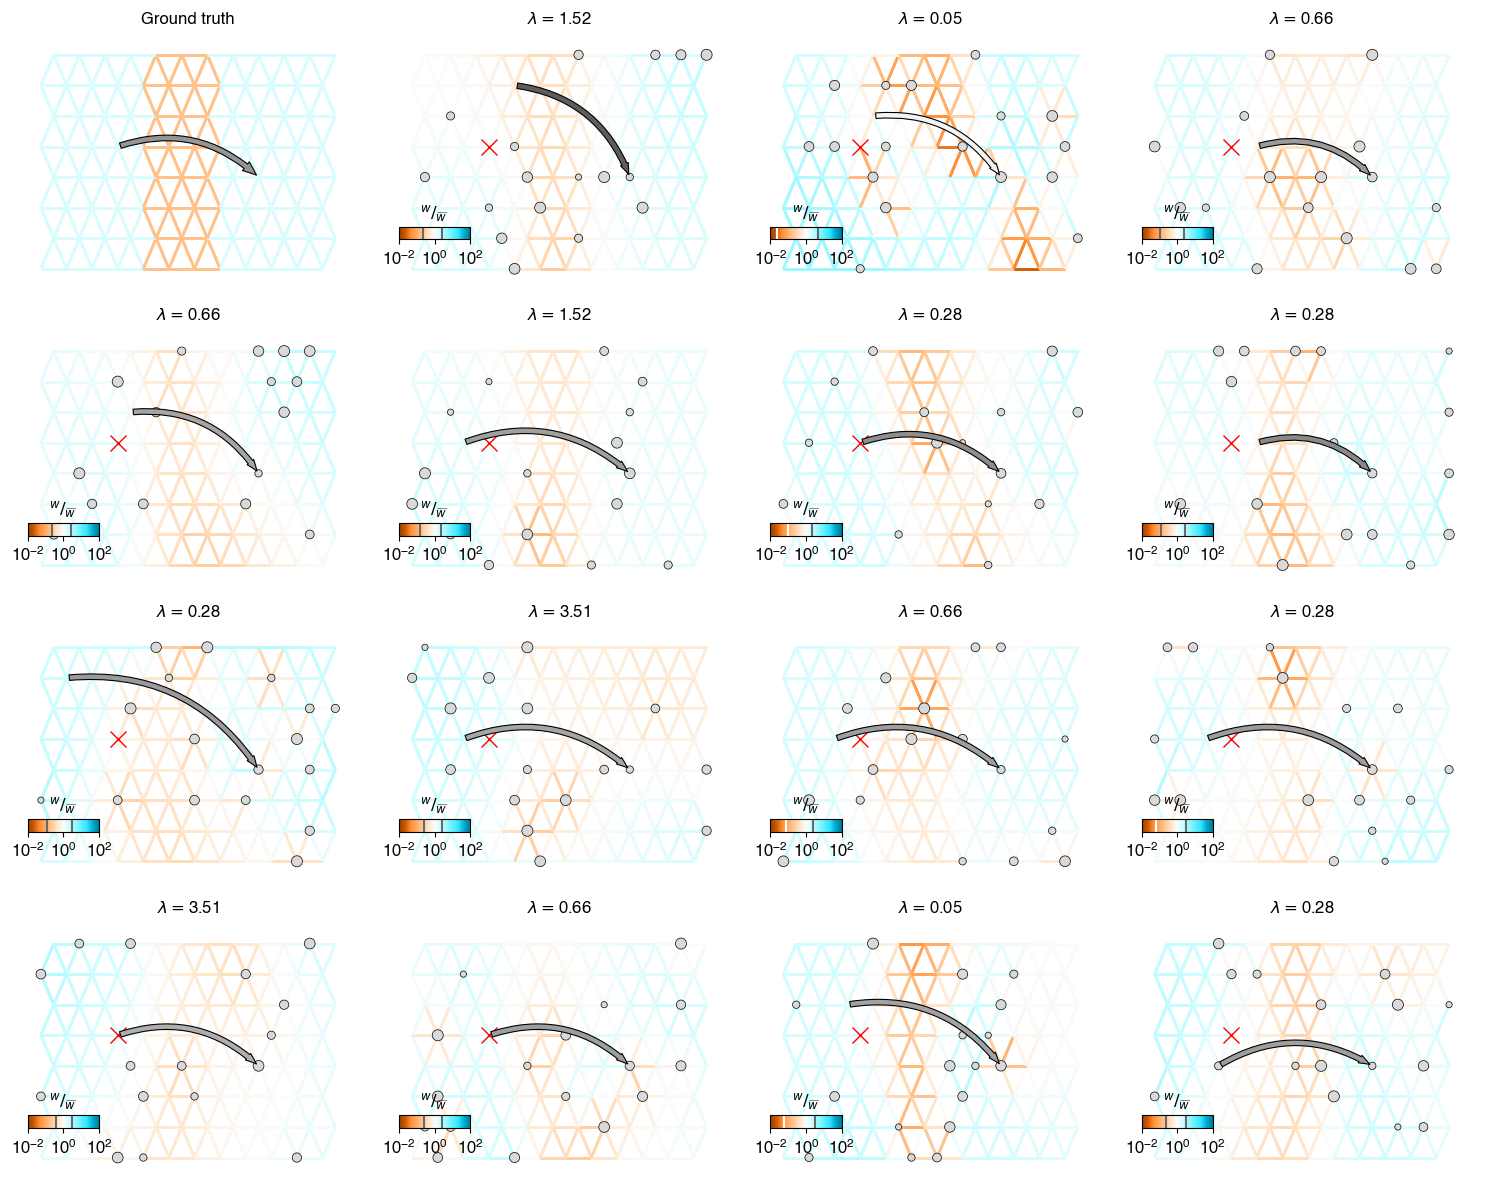

In [164]:
# with open('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp_sims.pkl', 'rb') as fp:
#     sims = pickle.load(fp)
# results = pd.read_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp.csv", index_col=0)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i==0:
        true_weights = get_true_weights(); true_weights[np.where(true_weights==0.5)[0]] = 0.01
        v = Viz(ax, sp_graph, projection=None)
        v.norm_log_weights = np.log10(true_weights) - np.mean(np.log10(true_weights))
        v.edge_width=2; v.abs_max = 2; v.obs_node_linewidth = 0.5; v.cbar_ticklabelsize = 12
        v.draw_edges(use_weights=True)
        v.draw_arrow([(51,44)],0.5,tw=4,hw=8,hl=10);
        v.ax.set_title('Ground truth')
        continue
        
    coord = sims[i][3][list(range(np.sum(sims[i][1][:51])//2))+list(range(np.sum(sims[i][1][:52])//2,np.sum(sims[i][1])//2)),:]
    gen_test = sims[i][0][list(range(np.sum(sims[i][1][:51])//2))+list(range(np.sum(sims[i][1][:52])//2,np.sum(sims[i][1])//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    ## creating the object
    sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
    sp_graph.fit(lamb=results['lamb_cv'].at[i], optimize_q='n-dim', lamb_q=results['lamb_q_cv'].at[i])

    inc = False
    try:
        sp_graph.fit(lamb=results['lamb_cv'].at[i], optimize_q='n-dim', lamb_q=results['lamb_q_cv'].at[i],
                     option='onlyc', long_range_edges=[(results['mle_joint_id'].at[i],44)])
    except: 
        inc = True
        sp_graph.fit(lamb=results['lamb_cv'].at[i]*2, optimize_q='n-dim', lamb_q=results['lamb_q_cv'].at[i],
                     option='onlyc', long_range_edges=[(results['mle_joint_id'].at[i],44)])

    v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, edge_alpha=1, 
            edge_zorder=100, sample_pt_size=20, obs_node_size=20, sample_pt_color="black", cbar_font_size=8)
    v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()
    v.draw_arrow([(results['mle_joint_id'].at[i],44)], sp_graph.c, tw=4,hl=8,hw=6)
    v.ax.plot(v.grid[51,0],v.grid[51,1],'rx',markersize=12)
    if inc:
        v.ax.set_title(r'$\lambda = ${:.2f}'.format(results['lamb_cv'].at[i]*2))
    else:
        v.ax.set_title(r'$\lambda = ${:.2f}'.format(results['lamb_cv'].at[i]))
plt.tight_layout(); plt.show()
fig.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/feemsmix_allreps.pdf')

In [293]:
# # MLEloc60 = np.zeros(10); MLEc60 = np.zeros(10); truell60 = np.zeros(10); truec60 = np.zeros(10)
# MLEloc = []; MLEdiff = []; MLEdf = pd.DataFrame(0, index=range(1,80), columns=['(source, dest.)','admix. prop.','log-lik','scaled log-lik']); MLEc = []; MLEidx = []; avgw = np.zeros(len(edge_def)) #MLEct = []; truect = []
# cnt = 0
# for i in range(16):
#     # coord = coord_def[list(range(220))+list(range(230,400)),:] #-> sparse sampling with only 10 nodes
#     # coord = coord[list(range(19))+list(range(20,36)),:]
#     # coord = coord_def[list(range(320))+list(range(330,490)),:]
#     # gen_test = gen_test_80[i][list(range(320))+list(range(330,490)),:]
#     # gen_test = gen_test[list(range(19))+list(range(20,36)),:]
#     # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
#     # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

#     sp_graph = FEEMSmix_SpatialGraph(gen_test_80[i], coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=10.,optimize_q='n-dim',lamb_q=30., verbose=False); 
#     obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

#     avgw += np.log10(sp_graph.w) - np.mean(np.log10(sp_graph.w))

#     top = obj.extract_outliers(0.001,verbose=False)
#     # df = obj.calc_contour(destid=20,search_area='all',exclude_boundary=False)
#     if len(top)==0:
#         cnt+=1
#     else:
#         df = obj.calc_contour(destid=int(top['dest.'][0]), search_area='all')

#     # MLEloc.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])])
#     MLEloc.append(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
#     MLEidx.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])
#     MLEc.append(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])])
#     # MLEdiff.append(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(63,20))[0]].values[0])

#     # if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]%2:
#     #     MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'sampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
#     # else:
#     #     MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
#     # truect.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(63,10)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    
#     MLEdf['(source, dest.)'] = df['(source, dest.)']
#     MLEdf['admix. prop.'] += df['admix. prop.']
#     MLEdf['scaled log-lik'] += df['scaled log-lik']
#     MLEdf['log-lik'] += df['log-lik']
#     # if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]==(63,20):
#     #     cnt += 1 

# MLEdf['admix. prop.'] /= 16
# MLEdf['scaled log-lik'] /= 16
# MLEdf['log-lik'] /= 16
# MLEdf['scaled log-lik'] -= np.max(MLEdf['scaled log-lik'])
# print('True source is MLE: {:d} times'.format(cnt))
# avgw /= 16

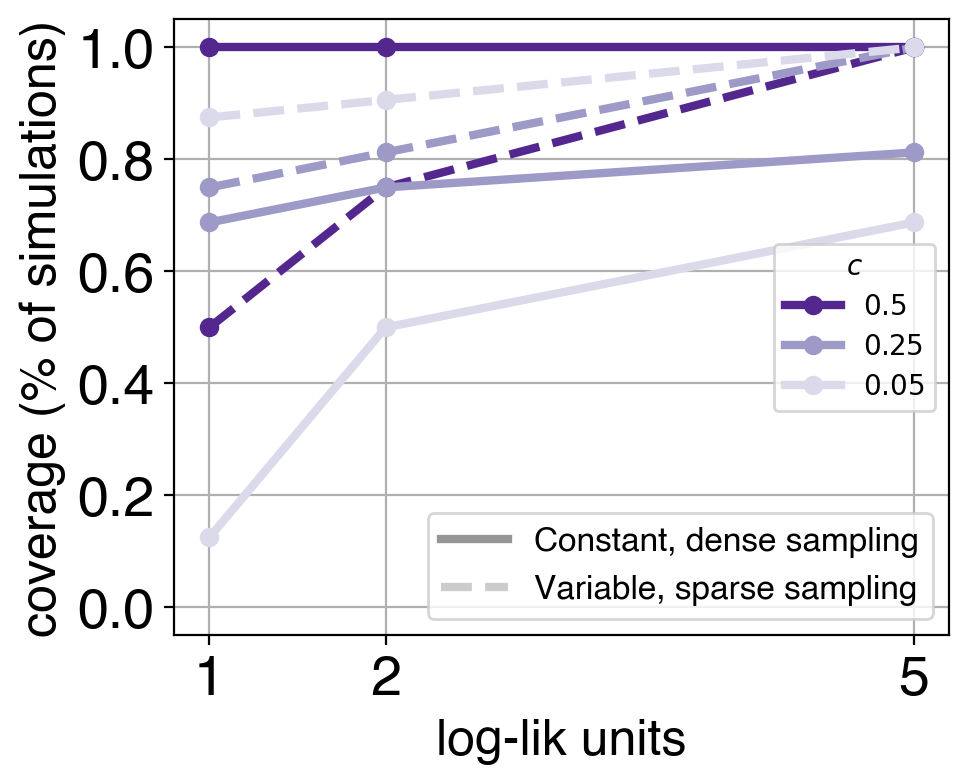

In [77]:
# plt.plot([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],'ko'); plt.axline((1,1),slope=1,color='grey',ls='--')
# plt.errorbar([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],yerr=2*np.array([0.022712280888398006,0.02512421169863045,0.027121704897425686,0.04519398722241161,0.04100375527102841,0.0613764922651444,0.09075075842841175,0.14649618822602764]),color='k'); plt.xlabel('msprime simulated weights'); plt.ylabel('FEEMS estimated weights'); plt.semilogx()
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]],'mode':'unsampled'},method='Nelder-Mead',bounds=[(0,1),(0,0.005)])
# sp.optimize.minimize(obj.neg_log_lik_c, 0.5, bounds=[(0.0,1)], args={'lre':[(46,8)],'mode':'unsampled'})
# np.where(MLEdf['scaled log-lik'].isna())
# plt.hist2d(np.array(MLEloc)[:,0],np.array(MLEloc)[:,1],cmap='Greens'); plt.ylim((0,6.5)); plt.xlim((0,10)); plt.colorbar()
# (np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)
# df = obj.calc_contour(destid=44,search_area='all',exclude_boundary=False)
from matplotlib.lines import Line2D
fig, ax = plt.subplots(dpi=200, figsize=(5,4))
ax.grid()
plt.yticks(np.linspace(0, 1, 6),fontsize=20)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('log-lik units',fontsize=18)
ax.set_ylabel('coverage (% of simulations)',fontsize=18)
plt.xticks([1, 2, 5],fontsize=20)

# Plotting the curves with different linestyles and colors
ax.plot([1, 2, 5], [1, 1, 1], '-o', color='#54278f', label=r'$0.5$', linewidth=3)
ax.plot([1, 2, 5], [0.5, 12/16, 1], '--o', color='#54278f', linewidth=3)
ax.plot([1, 2, 5], [11/16, 12/16, 13/16], '-o', color='#9e9ac8', label=r'$0.25$', linewidth=3)
ax.plot([1, 2, 5], [12/16, 13/16, 1], '--o', color='#9e9ac8', linewidth=3)
ax.plot([1, 2, 5], [2/16, 8/16, 11/16], '-o', color='#dadaeb', label=r'$0.05$', linewidth=3)
ax.plot([1, 2, 5], [14/16, 14.5/16, 1], '--o', color='#dadaeb', linewidth=3)

# Add the first legend for the color labels (c values)
c_legend = ax.legend(title=r'$c$', loc='center right',fontsize=10)
# Manually add this legend to the plot
ax.add_artist(c_legend)

legend_elements = [Line2D([0], [0], linestyle='-', linewidth=3, color='#969696', label='Constant, dense sampling'),
                   Line2D([0], [0], linestyle='--', linewidth=3, color='#cccccc', label='Variable, sparse sampling')]
# Add the second legend for line styles
ax.legend(handles=legend_elements, loc='lower right', title='',fontsize=12);
plt.show()

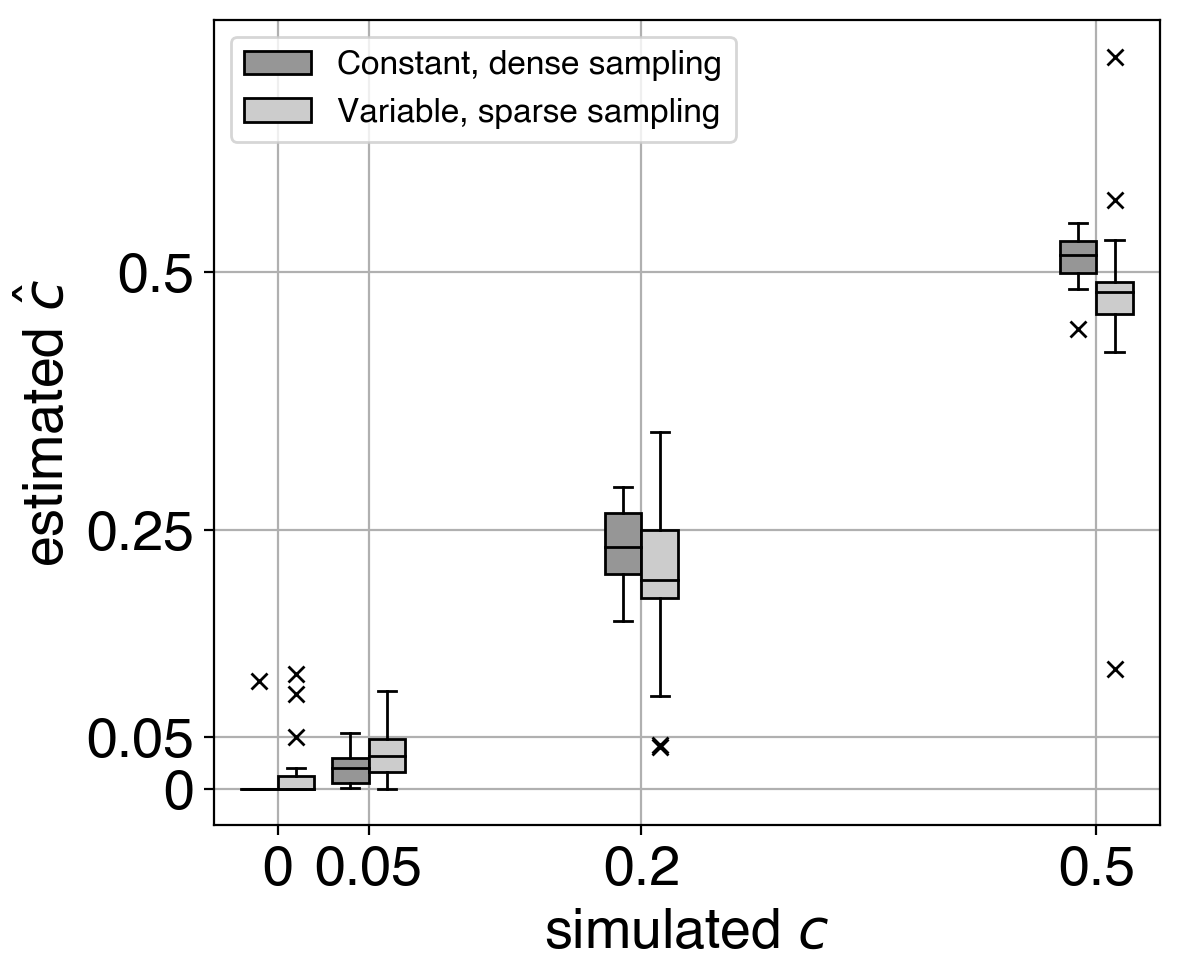

In [124]:
positions = [1, 2, 5, 10]
types = cdf['type'].unique()
colors = ['#969696', '#cccccc']

plt.figure(dpi=200, figsize=(6, 5))

for i, t in enumerate(types):
    data = [cdf[(cdf['sim'] == x) & (cdf['type'] == t)]['est'] for x in [0,0.05,0.25,0.5]]
    bp = plt.boxplot(data, positions=np.array(positions) + 0.2*(-1 if i == 0 else 1), 
                     widths=0.4, patch_artist=True, sym='x')
    plt.setp(bp['medians'], color='k')
    
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])

plt.xticks(ticks=[1,2,5,10],labels=[0,0.05,0.2,0.5], fontsize=20)
plt.yticks([0, 0.05, 0.25, 0.5], labels=['0', '0.05', '0.25', '0.5'], fontsize=20)
plt.ylabel(r'estimated $\hat c$', fontsize=20)
plt.xlabel(r'simulated $c$', fontsize=20)
plt.grid(True)

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=t) for i, t in enumerate(types)]
plt.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.show()

In [170]:
# plt.plot(range(1,11),[np.sum(np.array(MLEdiff)>-l)/16 for l in range(1,11)], 'k-o'); plt.xticks([1,2,5,10]); plt.title('True source is MLE: {:d} times'.format(np.sum(np.array(MLEdiff)==0)))
# cdf = pd.DataFrame(index=range(128),columns=['type','est','sim'])
# cdf['type']=['Constant, dense sampling']*16+['Variable, sparse sampling']*16+['Constant, dense sampling']*16+['Variable, sparse sampling']*16+['Constant, dense sampling']*16+['Variable, sparse sampling']*16 + ['Constant, dense sampling']*16+['Variable, sparse sampling']*16
# cdf['est']=[0.526243997568201,0.515832282148972,0.547158286406469,0.528469727408654,0.515891467999066,0.501976428381112,0.536779089300854,0.495932659907216,0.510538866658905,0.444425154101996,0.532517503840054,0.524307033680823,0.532209715124859,0.48290029642935,0.489565832408215,0.500413369492945]+[0.460213882750557,0.708107394009946,0.115497487111673,0.488703349686507,0.453648082703239,0.480217876628525,0.530709499038278,0.568986146053624,0.48772618697476,0.456834492696022,0.48591195292277,0.481378470559772,0.422216498490966,0.492806225636351,0.461841248628242,0.474006196658118]+[0]*15+[0.104]+[0]*11+[0.09142194, 0.11122939, 0.02, 0.05, 0.01] + [0.23615423470374683, 0.23179938547446116, 0.2910049338095276, 0.22772387631990645, 0.21058039229455994, 0.2592193237563318, 0.16549799034402231, 0.20008059020620725, 0.28013599814492435, 0.17345993464531526, 0.21005166710813566, 0.28364075919416515, 0.29204199343861753, 0.2408856355420014, 0.16258867411318714, 0.26260108165405196] + [0.244440404296691,0.188525157990772,0.247229707565476,0.345449493419359,0.192753490374773,0.244482087730159,0.0400225146796289,0.191039266899347,0.296804890719951,0.0897039218715909,0.208449574496328,0.195621873289763,0.259323695214876,0.276371921413037,0.0427969458051594,0.171116191917515] + [0.0541117849742431,0.0038843456228878,0.0487632499301195,0.0112401737299266,0.0246502323784948,0.032659059524575,0.0168100434305981,0.020213285555034,0.0015891220558444,0.00657740048485867,0.00438170011813944,0.0197457357562476,0.0365744194885901,0.000376149752115764,0.0292354675260732,0.0226764236878347] + [0.0672445144962976,0.0457088149081805,0.0179042142574769,0.0375618629734481,0.00808694857379862,0.0349400718920613,0.0293591346621945,0.0179468327996667,0,0.0132397139466538,0.03594603153297,0.0273964986182512,0.056869717816772,0,0.056589840026984,0.0948841124763724]
# cdf['sim'] = [0.5]*32+[0.]*32+[0.25]*32+[0.05]*32
# cdf['xpos'] = [10]*32+[0]*32+[5]*32+[1]*32
# sns.violinplot(data=cdf,x='type',y='est',palette=['#969696','#cccccc'],width=0.3); plt.ylim(-0.05,1.05); plt.axhline(0.5,color='red'); plt.ylabel(r'$\hat c$')
# plt.figure(dpi=200)
# sns.boxplot(data=cdf,x='xpos',y='est',hue='type',palette=['#969696','#cccccc'],width=0.5); plt.xticks(fontsize=20); plt.legend(fontsize=12); 
# plt.ylabel(r'estimated $\hat c$',fontsize=20);  plt.xlabel(r'simulated $c$',fontsize=20); plt.yticks([0,0.05,0.25,0.5],labels=['0.0','0.05','0.25','0.5'],fontsize=20); plt.grid()
cdf.groupby(['type','sim']).apply(lambda x: np.mean(x['est'] - x['sim']))

type                       sim 
Constant, dense sampling   0.00    0.006500
                           0.05   -0.029157
                           0.25   -0.017033
                           0.50    0.011573
Variable, sparse sampling  0.00    0.017666
                           0.05   -0.016020
                           0.25   -0.047867
                           0.50   -0.026950
dtype: float64

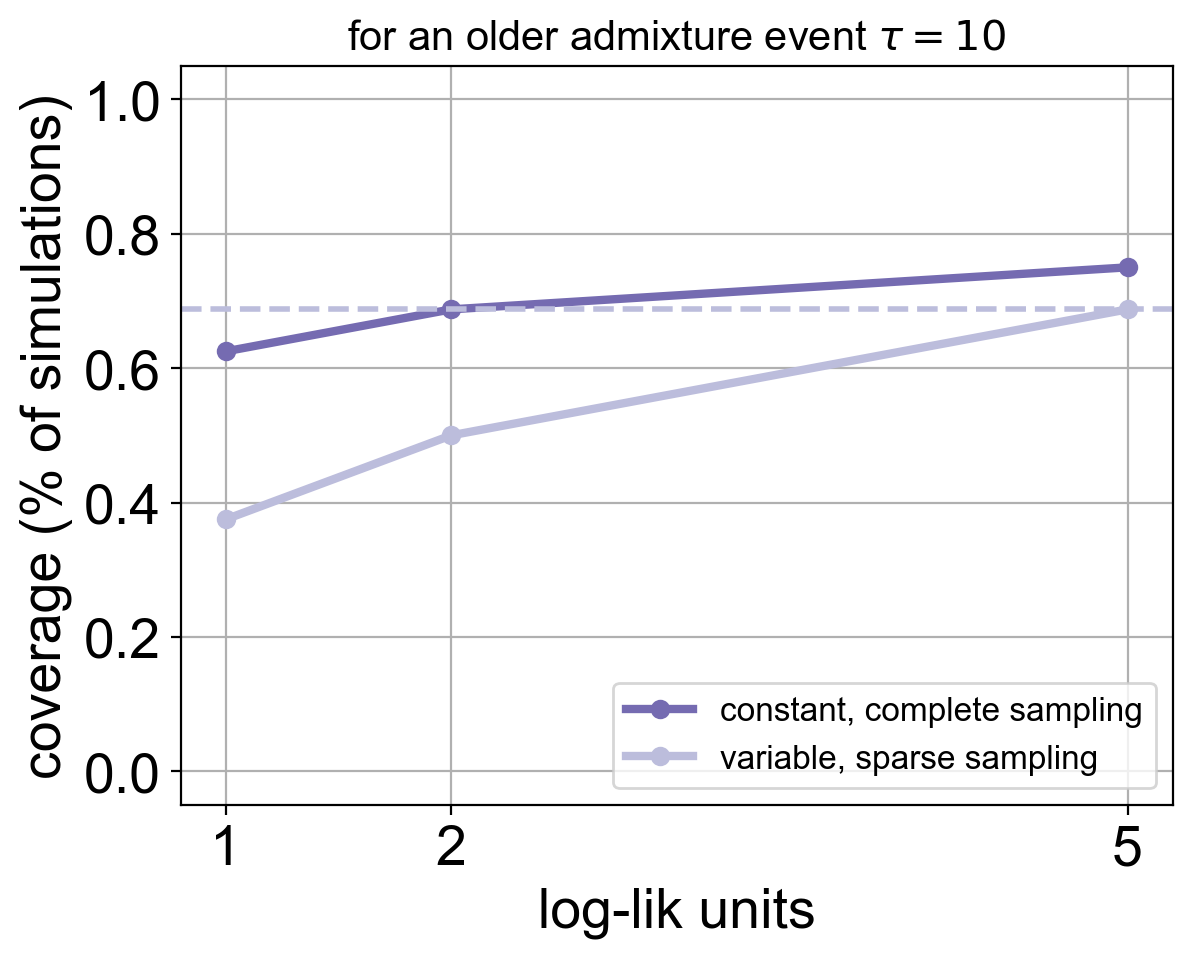

In [713]:
## for an older admixture event t=10 
# plt.figure(dpi=200); plt.grid(); plt.title(r'for an older admixture event $\tau=10$',fontsize=15)
# plt.plot([1,2,5],[10/16,11/16,12/16],'-o',color='#756bb1', label='constant, dense sampling', linewidth=3); plt.plot([1,2,5],[6/16,8/16,11/16],'-o',color='#bcbddc',label='variable, sparse sampling', linewidth=3); 
# plt.axhline(11/16,color='#bcbddc',linewidth=2,linestyle='--')
# plt.xticks([1,2,5],fontsize=20); plt.yticks(np.linspace(0,1,6),fontsize=20); plt.ylim(-0.05,1.05); plt.xlabel('log-lik units', fontsize=20); plt.ylabel('coverage (% of simulations)', fontsize=20); plt.legend(loc='lower right', fontsize=12)

# cdf = pd.DataFrame(index=range(32),columns=['type','est','sim'])
# cdf['type']=['constant, dense sampling']*16+['variable, sparse sampling']*16
# cdf['est']=[0.2162115889532034,0.21136211056123647,0.3475000101922749,0.3453746090463478,0.32227565191714685,0.35806049724124006,0.3425295972665616,0.3505314890244916,0.3188994047400839,0.32600764598537785,0.3525816528191607,0.34085022846749713,0.21914421438346302,0.2065479589732207,0.3193697380212831,0.21690661048091325]+[np.nan,0.241309467376551,0.0841475255408183,0.148944476342872,0.261890425403419,0.175454733469734,0.27338939308348,0.27869463704307,0.235760875441255,np.nan,0.238038575207611,np.nan,np.nan,np.nan,0.266443205129878,0.148871999568832]
# cdf['sim'] = [0.5]*32
# plt.figure(dpi=200); plt.title(r'for an older admixture event $\tau=10$',fontsize=15)
# sns.boxplot(data=cdf,x='sim',y='est',hue='type',palette=['#756bb1','#bcbddc'],width=0.5); plt.xticks(fontsize=20); plt.legend(fontsize=12)
# plt.ylabel(r'estimated $\hat c$',fontsize=20);  plt.xlabel(r'simulated $c$',fontsize=20); plt.yticks([0,0.25,0.5],labels=['0.0','0.25','0.5'],fontsize=20); plt.grid()

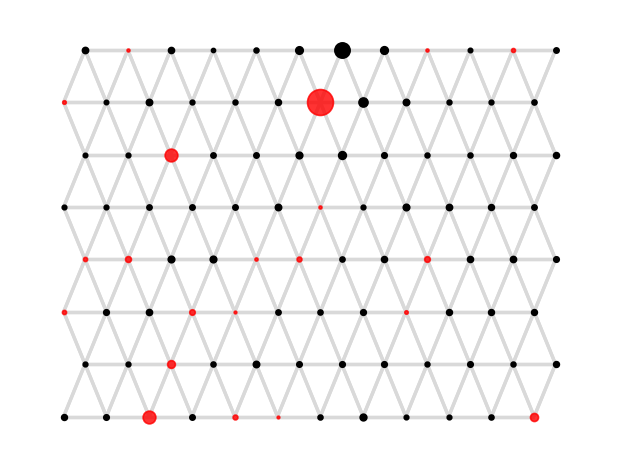

In [46]:
# np.array(MLEloc).std(axis=0)
# np.array(MLEloc).std(axis=0), np.array(MLEloc).mean(axis=0)
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); #v.draw_edge_colorbar()
q = []
for i in range(96):
    ip = np.where(obj.perm_idx==i)[0][0]
    if ip<sp_graph.n_observed_nodes:
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=20/sp_graph.q[ip])
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=np.linspace(1,8,80,endpoint=True)[i])#np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25)))[i]/5)
    else:
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,ip].T + np.diag(obj.Linv) + obj.Lpinv[ip,ip])
        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=ip,target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([ip])])[:10]
        # qprox = np.dot(1/sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        q.append(qprox)
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', markersize=20*qprox)
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', alpha=0.8, markersize=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20)))[i])

In [530]:
joint_df.iloc[:50]
# sp_graph.calc_contour(destid=44,exclude_boundary=False,).iloc[50:]

,"(source, dest.)",admix. prop.,log-lik,scaled log-lik,pval
1,"(0, 44)",0.494423,-704.528283,-9.805521,1.118004e-42
2,"(1, 44)",0.493987,-701.515277,-6.792515,5.408944e-44
3,"(2, 44)",0.510895,-699.064639,-4.341877,4.607198e-45
4,"(3, 44)",0.526707,-703.142711,-8.419949,2.776796e-43
5,"(4, 44)",NaN,NaN,NaN,NaN
6,"(5, 44)",0.302668,-759.881013,-65.158251,1.898763e-18
7,"(6, 44)",0.108733,-793.169778,-98.447017,1.392888e-03
8,"(7, 44)",0.622232,-765.229689,-70.506927,4.296244e-16
9,"(8, 44)",0.448339,-782.995192,-88.272430,3.229725e-08
10,"(9, 44)",0.000000,-813.077224,-118.354462,1.000000e+00


In [493]:
# plt.plot(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); plt.semilogx()
# plt.plot(np.arange(1,81),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); 
# np.mean(sp_graph.q)

# sp.stats.linregress(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,)
# print(sp.stats.linregress(np.arange(1,81),1/sp_graph.q))
# sp_graph.fit(lamb=2.,optimize_q='n-dim',lamb_q=2.)
# obj = Objective(sp_graph)
# delta = obj._compute_delta_matrix(0.5, {'update':'compute', 'lre':[(60,10)]})
# cov = 0.5 * (-delta + np.mean(delta, axis=1, keepdims=True) + np.mean(delta, axis=0) - np.mean(delta))
# # plt.imshow(cov-sp_graph.S); plt.colorbar()
# R = sp_graph.S - cov
# 1-np.sum((R[np.tril_indices(R.shape[0],k=-1)]-np.mean(R[np.tril_indices(R.shape[0],k=-1)]))**2)/np.sum((cov[np.tril_indices(cov.shape[0],k=-1)]-np.mean(cov[np.tril_indices(cov.shape[0],k=-1)]))**2)
# df = sp_graph.calc_contour(destid=44,exclude_boundary=False); df.iloc[np.argmax(df['log-lik'])]
joint_df = sp_graph.calc_joint_contour(lamb=.2, lamb_q=1.,destid=44,exclude_boundary=False,)

# plt.plot(jointll[:53],pointll[:53],'o',alpha=0.7); plt.grid()
# for rep in range(1,10):
#     plt.plot(jointll[(rep*53):(rep+1)*53],pointll[(rep*53):(rep+1)*53],alpha=0.7)
# plt.axline((-650,-650),slope=1,color='red')
# plt.xlabel('log-likelihood from joint fit'); plt.ylabel('log-likelihood from point fit')
# plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/point_joint.pdf')
# plt.hist(joint_df['log-lik']); plt.hist(df['log-lik'],alpha=0.6)

	Jointly optimizing likelihood over 5/89 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 4, increase atol or factr slightly)
(Warning: admix. prop. optimization failed for deme 4, increase atol or factr slightly)
	Jointly optimizing likelihood over 6/89 most likely demes in the graph

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


	Jointly optimizing likelihood over 15/89 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:456: RuntimeWarning: overflow encountered in exp
  # if obj.optimize_q is not None:
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:332: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:205: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1*np.exp(-np.abs(rsm-R1)/rsd)/np.sum(1/R1*np.exp(-np.abs(rsm-R1)/rsd)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:209: RuntimeWarning: divide by zero encountered in divide
  resmat[i,did] = (1-self.sp_graph.c)*(Rmat[i,did]) + self.sp_graph.c*Ri1 + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + 1/self.sp_graph.q[i] + (1-self.sp_graph.c)/self.sp_graph.q[did] + self.sp_graph.c*qprox
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:

	Jointly optimizing likelihood over 49/89 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:62: RuntimeWarning: invalid value encountered in matmul
  X = U - np.outer(v, v @ B) / denom
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  resmat[i,did] = (1-self.sp_graph.c)*(Rmat[i,did]) + self.sp_graph.c*Ri1 + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + 1/self.sp_graph.q[i] + (1-self.sp_graph.c)/self.sp_graph.q[did] + self.sp_graph.c*qprox
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:431: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array(resmat)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:475: RuntimeWarning: overflow encountered in multiply
  grad[:n_edges] = obj.grad_obj * obj.sp_graph.w + obj.grad_pen * obj.sp_graph.w


	Jointly optimizing likelihood over 89/89 most likely demes in the graph...done!


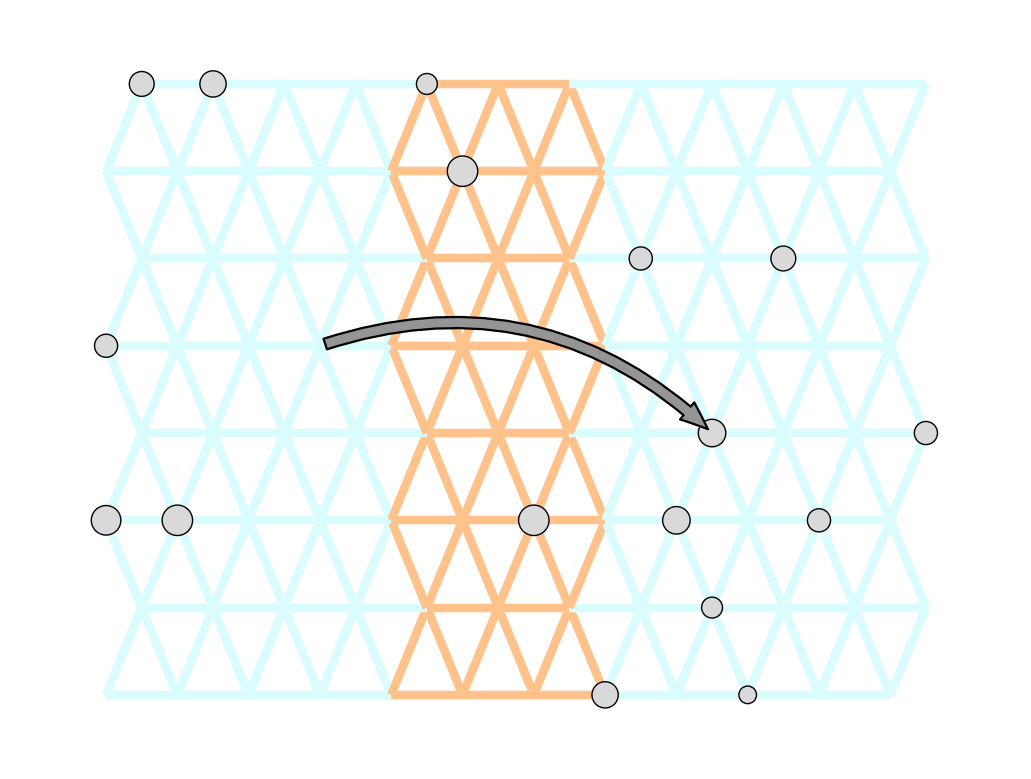

In [159]:
def get_true_weights(barrier_w=1e-3, corridor_w=1e-2, n_rows=8, n_columns=12, barrier_startpt=4, barrier_endpt=7):
    graph, coord, grid, edges = setup_graph_long_range(n_rows=n_rows,
                                            n_columns=n_columns,
                                            barrier_startpt=barrier_startpt,
                                            barrier_endpt=barrier_endpt,
                                            barrier_w=barrier_w,
                                            corridor_w=corridor_w)
    W = nx.adjacency_matrix(graph, weight="w")
    idx = nx.adjacency_matrix(graph).nonzero()
    idx = list(np.column_stack(idx))
    true_weights = np.array([])
    for i in range(len(idx)):
        true_weights = np.append(true_weights, W[idx[i][0],idx[i][1]])
    
    return(true_weights)

true_weights = get_true_weights(); true_weights[np.where(true_weights==0.5)[0]] = 0.01
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=None)
v.norm_log_weights = np.log10(true_weights) - np.mean(np.log10(true_weights))
v.obs_node_size = 40; v.edge_width=3; v.abs_max = 2; v.obs_node_linewidth = 0.5; v.cbar_ticklabelsize = 12
# v.cbar_width = "20%"; v.cbar_height = "5%"; v.cbar_loc = "lower left"; v.cbar_bbox_to_anchor = (0.05, 0.2, 1, 1)
# v.draw_edge_colorbar()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.draw_arrow([(51,44)],0.5,tw=4,hw=8,hl=10);

## Jointly estimating $w, q$ and $c$ using $\texttt{scipy.optimize}$ and a function with computed gradients 

Issue currently is that this scheme just draws all weights to the average value (typically, $\bar w \approx 1.1$), but estimates $c$ correctly. What if I use a different function with precomputed weights?

In [101]:
## graph setup
# sampnodes = [2,14,18,25,31,44,46,51,57,66,74,77]
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=500, long_range_nodes=[(51,44)], admixture_props=[0.3], n_e=100, time_of_adm=[1e-7])
# coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = gen_test_80[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
# sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)


 fold:  0
iteration lambda=12/12 lambda_q=5/5
 fold:  1
iteration lambda=12/12 lambda_q=5/5
 fold:  2
iteration lambda=12/12 lambda_q=5/5
 fold:  3
iteration lambda=12/12 lambda_q=5/5
 fold:  4
iteration lambda=12/12 lambda_q=5/5
 fold:  5
iteration lambda=12/12 lambda_q=5/5
 fold:  6
iteration lambda=12/12 lambda_q=5/5
 fold:  7
iteration lambda=12/12 lambda_q=5/5
 fold:  8
iteration lambda=12/12 lambda_q=5/5
 fold:  9
iteration lambda=12/12 lambda_q=5/5
 fold:  10
iteration lambda=12/12 lambda_q=5/5
 fold:  11
iteration lambda=12/12 lambda_q=5/5
 fold:  12
iteration lambda=12/12 lambda_q=5/5
 fold:  13
iteration lambda=12/12 lambda_q=5/5
 fold:  14
iteration lambda=12/12 lambda_q=5/5

Text(0, 0.5, 'LOO-CV error')

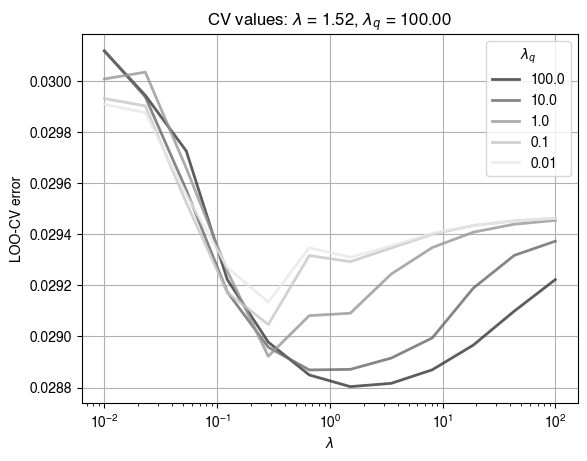

In [626]:
lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]
lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
cvq_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=None, factr=1e7)
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); 
# plt.plot(lamb_q_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

mean_cv_err = np.nanmean(cvq_err, axis=0)
plt.gca().set_prop_cycle(color=[plt.get_cmap('Greys_r').resampled(len(lamb_q_grid)+2)(i) for i in range(1,len(lamb_q_grid)+1)])
lineObj = plt.plot(lamb_grid, mean_cv_err.T, linewidth=2, alpha=0.8)
plt.title(r'CV values: $\lambda$ = {:.2f}, $\lambda_q$ = {:.2f}'.format(lamb_grid[np.where(mean_cv_err == np.min(mean_cv_err))[1][0]],lamb_q_grid[np.where(mean_cv_err == np.min(mean_cv_err))[0][0]]))
plt.legend(lineObj, lamb_q_grid, title=r'$\lambda_q$'); plt.grid(); plt.xlabel(r'$\lambda$'); plt.semilogx(); plt.ylabel('LOO-CV error')
# print(np.where(np.nanmin(np.nanmean(cvq_err,axis=0))==np.nanmean(cvq_err,axis=0))[1][0])
# np.geomspace(1e-2,1e2,6,endpoint=True)[::-1][3], lamb_grid[5]

In [563]:
# sp_graph.fit(lamb=0.01,optimize_q=None,lamb_q=1.); obj = Objective(sp_graph); 
# obj.inv(); obj.grad(reg=False); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense())

# oldw = deepcopy(sp_graph.w); olds2 = deepcopy(sp_graph.s2)
# print(obj.eems_neg_log_lik(), sp_graph.c) # -> 813.9
# df = obj.calc_contour(destid=44,exclude_boundary=False)
# joint_contour
# np.max(joint_df['log-lik'].loc[:0])
# joint_contour, obj.calc_contour(44,sourceid=51,search_area='radius',opts=2)
# joint_contour, joint_df.loc[topidx-1], df.loc[topidx]
# outliers_df = sp_graph.extract_outliers()

AttributeError: 'Objective' object has no attribute 'calc_joint_contour'

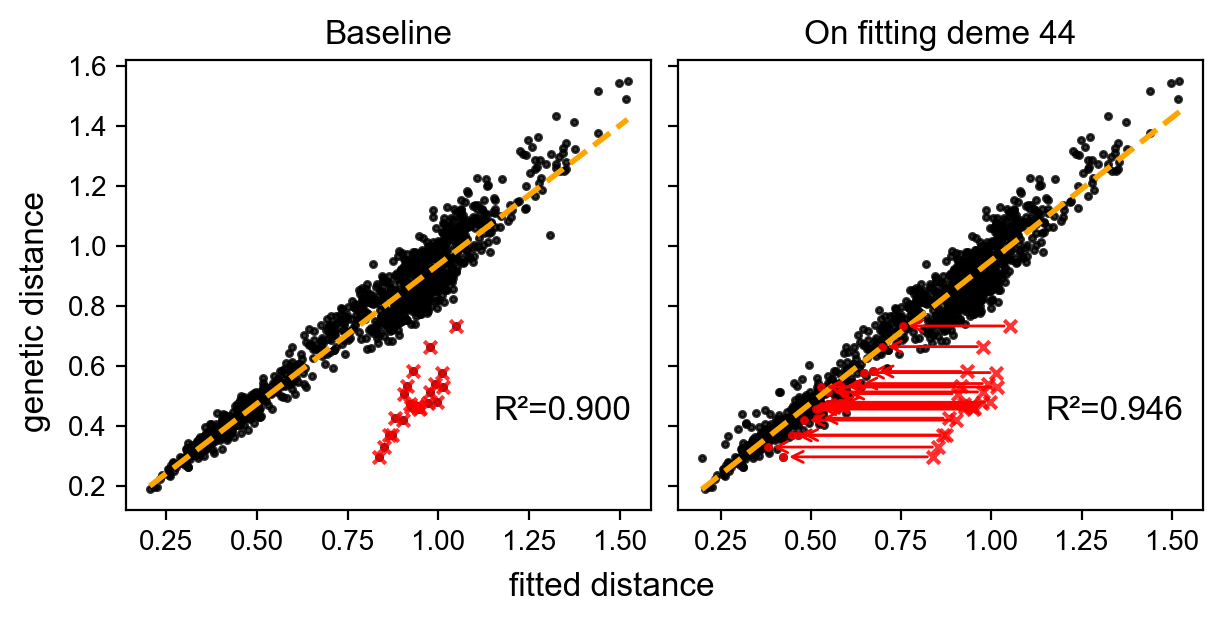

In [1111]:
# seq_results = sp_graph.independent_fit(sp_graph.extract_outliers(fdr=0.2), lamb=10., lamb_q=100., optimize_q='n-dim', top=2)

plot_FEEMSmix_result(seq_results, dpi=200, figsize=(6,3))

# joint_df.iloc[np.argmax(joint_df['scaled log-lik'])]
# plt.hist(df['log-lik'] - joint_df['log-lik'],20)
# plt.figure(dpi=150)
# plt.plot(range(95), np.array(joint_df['log-lik']) - np.array(df['log-lik']), 'ko',); plt.ylabel("increase in log-lik with a 'joint' fit")
# plt.xticks(range(95),labels=[i for i in range(96) if i != 44],rotation=45, fontsize=4); 
# sp.stats.chi2.sf(2*(np.array(joint_df['log-lik']) - np.array(df['log-lik'])), 100)

# plt.figure(dpi=150); plt.axhline(2*840, color='red')
# plt.plot(range(95), 2*264-2*joint_df['log-lik'], 'o', color='#66c2a5', label='joint'); plt.plot(range(95), 2 - 2*df['log-lik'], 'o', alpha=0.8, color='#fc8d62', label='point'); 
# plt.xticks(range(95),labels=[i for i in range(96) if i != 44],rotation=45, fontsize=4); plt.legend(title='method'); plt.ylabel('log-lik')

In [452]:
joint_df = sp_graph.calc_joint_contour(destid=44,search_area='custom',opts=[12,35,41,42,51],lamb=.2,lamb_q=1.,exclude_boundary=False)
joint_df
# obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False); obj.Lpinv = sp.linalg.pinvh(sp_graph.L.todense())
# sp.optimize.minimize(obj.eems_neg_log_lik, x0=np.random.random(), args={'edge':[(51,44)],'mode':'compute'},method='L-BFGS-B')
# obj.sp_graph.c = 0.5
# x0 = np.r_[np.log(obj.sp_graph.w), np.log(obj.sp_graph.s2)]
# obj.alpha=1/sp_graph.w.mean(); obj.alpha_q=1/sp_graph.s2.mean(); obj.lamb=0.2; obj.lamb_q=1.
# sp.optimize.fmin_l_bfgs_b(
#             func=loss_wrapper,
#             x0=x0,
#             args=[obj],
#             factr=1e7,
#             m=10,
#             maxls=50,
#             maxiter=100,
#             approx_grad=False,
#         )

	Jointly optimizing likelihood over 5/5 most likely demes in the graph...done!


,"(source, dest.)",admix. prop.,log-lik,scaled log-lik,pval
1,"(35, 44)",0.000000,-595.799514,-79.100384,1.081594e-03
2,"(41, 44)",0.410395,-563.656833,-46.957703,4.784623e-18
3,"(42, 44)",0.007682,-598.729667,-82.030537,2.809711e-02
4,"(12, 44)",0.443047,-524.407396,-7.708265,3.028937e-35
5,"(51, 44)",0.507640,-516.699130,0.000000,1.297471e-38


In [554]:
# sp_graph.fit(lamb=3.,lamb_q=1.,optimize_q='n-dim',option='default')
# obj = Objective(sp_graph)
# sp.optimize.minimize(obj.eems_neg_log_lik, x0=0.1, args={'edge':[(52,44)],'mode':'compute'}, method='Nelder-Mead', bounds=[(0,1)])
# outliers_df = sp_graph.extract_outliers(fdr=0.25)
# df = sp_graph.calc_contour(destid=44,exclude_boundary=False)
# df.iloc[5:60]
# sp_graph.fit(lamb=.2,long_range_edges=[(24,44)],optimize_q='n-dim',lamb_q=1.,option='onlyc'); print(sp_graph.c)
# obj = Objective(sp_graph)
# obj.eems_neg_log_lik(1, {'mode':'compute','edge':[(51,44)]})
# plt.plot(np.linspace(0,0.5,20),[-obj.eems_neg_log_lik(c, {'mode':'compute','edge':[(49,44)]}) for c in np.linspace(0,0.5,20)],'ko')

  Optimizing likelihood over 89 demes in the graph...25%...

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


50%...75%...done!


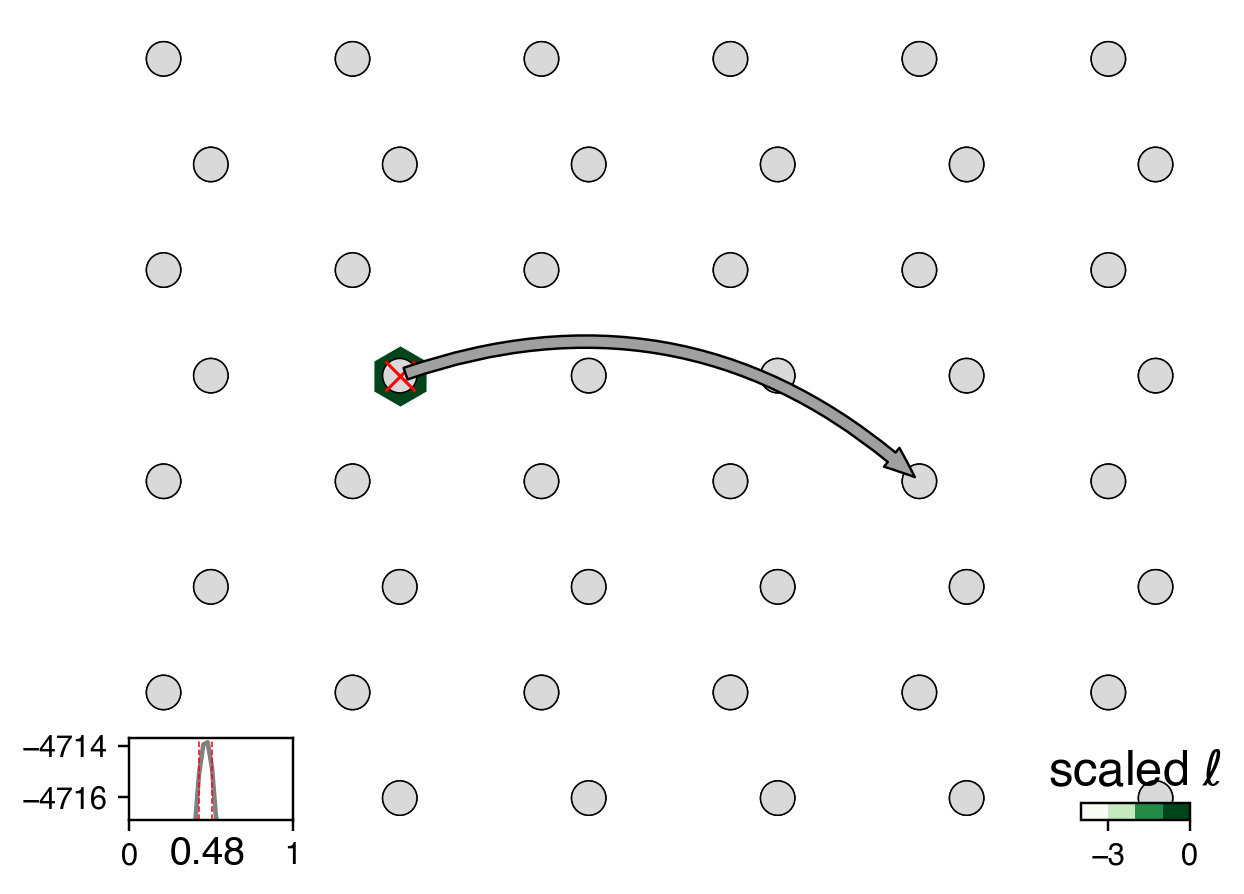

In [558]:
fig = plt.figure(dpi=220)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=None, edge_width=3, abs_max=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=40, sample_pt_color="black", cbar_font_size=20, cbar_ticklabelsize=16)
# v.draw_edges(use_weights=True); v.draw_edge_colorbar(); 
v.draw_obs_nodes();
# for i in range(outliers_df.shape[0]):
#     v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=1,color='grey')
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=20*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)
v.draw_loglik_contour(df, loglik_node_size=200,levels=-3,magnifier=50); v.draw_obs_nodes(use_ids=False); 
# v.draw_c_contour(df)
v.ax.plot(v.grid[51,0],v.grid[51,1],'rx',markersize=10,linewidth=20)
# v.draw_arrow([(51,44)],0.5,tw=4.5,hw=8,hl=10)

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, oldweights=oldw, halfrange=100,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar(); v.draw_obs_nodes()

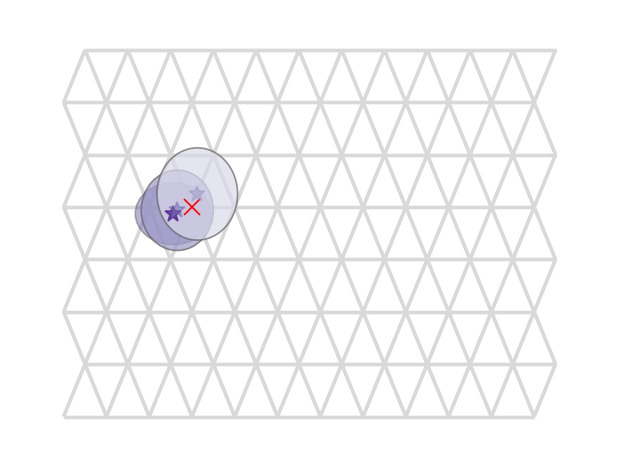

In [44]:
from matplotlib.patches import Ellipse
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False)
# v.ax.plot(v.grid[51,0],v.grid[51,1],'*',color='darkgreen',markersize=10)
v.ax.plot(v.grid[51,0],v.grid[51,1],'rx',markersize=10)
## mean: 2.40625 3.951241, sd: 1.0834936 0.8926786 for c=0.5 & t=10 (sparse sampling)
## mean: 2.875 3.13934, sd: 0.5 0.53619 for c=0.5 & t=10 (dense sampling)
# v.ax.plot(3, 3.46410162, '*', color='#54278f', alpha=0.8, markersize=10)
# v.ax.add_patch(Ellipse([3, 3.46410162], width=2*0.2, height=2*0.2, alpha=0.5, facecolor='#756bb1', edgecolor='#636363'))
# v.ax.plot(2.906250, 3.626481, '*', color='#756bb1', markersize=10, alpha=0.5)
# v.ax.add_patch(Ellipse([2.906250, 3.626481], height=2*0.4552929, width=2*0.4710361, alpha=0.7, facecolor='#9e9ac8', edgecolor='#636363'))
# v.ax.plot(2.875, 3.788861, '*', color='#9e9ac8', markersize=10, alpha=0.5)
# v.ax.add_patch(Ellipse([2.875, 3.788861], height=2*0.5123475, width=2*0.5627314, alpha=0.7, facecolor='#dadaeb', edgecolor='#636363'))
v.ax.plot(2.5625, 3.355848, '*', color='#54278f', alpha=0.8, markersize=10)
v.ax.add_patch(Ellipse([2.5625, 3.355848], height=2*0.5123475, width=2*0.8874120, alpha=0.5, facecolor='#756bb1', edgecolor='#636363'))
v.ax.plot(2.65625, 3.409975, '*', color='#756bb1', markersize=10, alpha=0.5)
v.ax.add_patch(Ellipse([2.65625, 3.409975], height=2*0.6637626, width=2*0.8420722, alpha=0.7, facecolor='#9e9ac8', edgecolor='#636363'))
v.ax.plot(3.125, 3.680608, '*', color='#9e9ac8', markersize=10, alpha=0.5)
v.ax.add_patch(Ellipse([3.125, 3.680608], height=2*0.7627314, width=2*0.9416198, alpha=0.7, facecolor='#dadaeb', edgecolor='#636363'))

In [1673]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(100)]
# randedge = list(set(randedge)-set(sp_graph.edges))
# randedge = [(x,58) for x in list(set(range(144))-set([58]))] 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,0,0,0])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55),(12,56),(13,56),(32,56)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def); 
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    if e[0]<80:
        res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_demes_nll_w_c, x0=0.5, method='Nelder-Mead', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        isc2[ie] = res.x; llc2[ie] = res.fun
    else:
        res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_udemes_nll_w_c, x0=0.5, method='L-BFGS-B', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        # sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[e]); sp_graph.c
        isc2[ie] = res.x #sp_graph.c; 
        llc2[ie] = res.fun #obj.neg_log_lik_c(sp_graph.c)
    # isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).fun
    # isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

### Effect of changing $Nm$ on $\hat c$ AND is there a scaling parameter $\sigma^\star$ that I need to worry about?
### (or is it just $\approx 1$?)

For $6\times6$ grid with $Nm=1$, it is around 1 (tested for $c \in \{0, 0.5\}$). It is slightly less than 1 $(0.988)$ for $Nm=0.01$, and the $c$ estimates are upward biased as seen above (expected). The bias is smaller but still negative for a larger grid of $8 \times 12$. 

In [759]:
# n_rows, n_columns = 6, 6
# estchalf = np.zeros((10,3)); estsighalf = np.zeros((10,3))
# for iNm, Nm in enumerate([(100,1e-3),(100,1e-2),(100,1e-1)]):
#     print(Nm[0], Nm[1])
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=Nm[1], barrier_w=Nm[1], barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
#     foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=300, long_range_nodes=lrn, admixture_props=[c], n_e=Nm[0], time_of_adm=[0.000001])
#     gen_test_80 = Parallel(n_jobs=10)(delayed(foo)(0.5) for _ in range(10))
#     for n in range(10):
#         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne100_sim{}.csv".format(50,n),gen_test_80[n],delimiter=',',fmt='%f')
#         # gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne10_sim{}.csv".format(50,n),delimiter=',')
#         sp_graph = FEEMSmix_SpatialGraph(gen_test_80[n], coord_def, grid_def, edge_def)
#         sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
#         obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
#         estchalf[n,iNm], estsighalf[n,iNm] = sp.optimize.minimize(obj.eems_neg_log_lik_sigma,x0=[0.5, 0],args=({'edge':[(8,27)],'mode':'compute'}),bounds=[(0,1),(-2,2)],method='L-BFGS-B').x
#         print(estchalf[n,iNm], np.exp(estsighalf[n,iNm]))
# obj.calc_contour(destid=27)

(960, 2000)

In [757]:
Gi = obj.sp_graph.genotypes[sp_graph.nodes[sp_graph.perm_idx[7]]['sample_idx'], :].astype('int').T
Ga1 = np.zeros((Gi.shape[0], Gi.shape[1], 2), dtype=int)
Ga1[Gi == 1, 1] = 1
Ga1[Gi == 2, 0] = 1; Ga1[Gi == 2, 1] = 1

Gi = obj.sp_graph.genotypes[sp_graph.nodes[sp_graph.perm_idx[9]]['sample_idx'], :].astype('int').T
Ga2 = np.zeros((Gi.shape[0], Gi.shape[1], 2), dtype=int)
Ga2[Gi == 1, 1] = 1
Ga2[Gi == 2, 0] = 1; Ga2[Gi == 2, 1] = 1

allel.average_hudson_fst(allel.GenotypeArray(Ga1).count_alleles(), allel.GenotypeArray(Ga2).count_alleles(), blen=int(obj.sp_graph.genotypes.shape[1]/10))[0]

IndexError: index 70 is out of bounds for axis 0 with size 57

In [475]:
# allel.GenotypeArray(Ga2)[422,:5], Gi[422,:5]
sp_graph.genotypes.shape

(1080, 1000)

In [1036]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.1, barrier_w=0.1, barrier_prob=1.0, 
#                                                        corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=20)

# lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=500, n_print=100, mu=1, long_range_nodes=lrn, n_e=np.repeat(1,8*12),
#                                                  admixture_props=[0.], time_of_adm=[0.000001])
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                        barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10)

# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=2000, n_print=1000, mu=1e-3, long_range_nodes=[(51,44)], 
#                                                  admixture_props=[0.5], time_of_adm=[1e-6]) # Ne=1,100,1000,10000: 1.5mins
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q=None,lamb_q=1.,)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# estcR2mat = np.zeros((16,5)) 
# estcllmat = np.zeros((16,5))
# trueid = np.zeros((16,5))
# for ic, truec in enumerate([0,0.25,0.5,0.75,1.]):
#     for n in range(16):
#         ## gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
#         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
#         gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
#         sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, scale_snps=True)
#         sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
#         obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
#         # sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False)
#         # estcllmat[n,ic] = sp_graph.c
#         estcllmat[n,ic] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
#         print(estcllmat[n,ic])
#         # fit_cov, _, emp_cov = comp_mats(obj)
#         # fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
#         # emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
#         # estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
#         # estcllmat[n,ic] = sp.stats.norm.cdf(np.min(np.log(emp_dist/fit_dist)),np.mean(np.log(emp_dist/fit_dist)),np.std(np.log(emp_dist/fit_dist)))
#         # Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
#         # Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
#         # resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
#         # llnull = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
#         # sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, option='joint', long_range_edges=lrn, verbose=False)
#         # estcR2mat[n,ic] = sp_graph.c

#         # if truec>0:
#         #     lle, te = get_best_lre(sp_graph,k=1,top=20)
#         #     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', long_range_edges=lrn, verbose=False); sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False)
#         #     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#         #     estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
#         #     if te.iloc[np.argmax(lle),0]==(8,27):
#         #         trueid[n,ic] = 1

In [1027]:
# sp.optimize.minimize(obj.eems_neg_log_lik, x0=0.5, bounds=[(0,1)], method='Nelder-Mead', args={'edge':[(8,27)], 'mode':'compute'}, tol=1e-2)
# sp.optimize.minimize(obj.eems_neg_log_lik_sigma, x0=[0.5, -0.5], bounds=[(0,1),(-2,2)], method='L-BFGS-B', args={'edge':[(8,27)], 'mode':'compute'}, tol=1e-3)

<Figure size 1280x960 with 0 Axes>

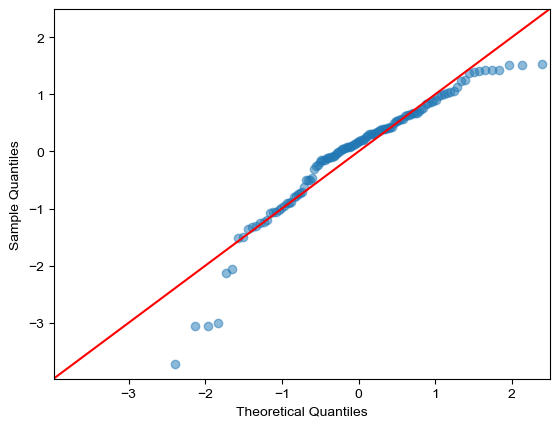

In [1039]:
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi
# het_white(reswt.resid,X)
# res.get_robustcov_results(cov_type='HC0').pvalues
# studentized_residuals = olsi(reswt).resid_studentized
# leverage_pts = olsi(reswt).hat_matrix_diag
# cook_dist = olsi(reswt).cooks_distance

# sm.graphics.influence_plot(reswt, alpha  = 1e-6, criterion="cooks", plot_alpha=0.5)
# k = 61; x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)
# sns.residplot(x=X, y=emp_dist, lowess=True, color='grey'); 
# plt.plot(fit_dist,reswt.resid,'ko',alpha=0.3); plt.plot(fit_dist,res.resid,'bx',alpha=0.3)
# sm.OLS(emp_dist/fit_dist, fit_dist).fit().summary()
# plt.plot(emp_dist/fit_dist,fit_dist,'ko',alpha=0.3); 
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-3*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),15,color='grey'); plt.axvline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--')
# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)<-3*np.std(emp_dist/fit_dist))
plt.figure(dpi=200)
sm.qqplot((np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)))/np.std(np.log(emp_dist/fit_dist)),line='45',alpha=0.5); 
# plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/qq_nolre.pdf')

# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),loc=0,scale=np.std(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0.5$');

# plt.hist(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),15,color='grey'); plt.axvline(-4*np.std(np.log(emp_dist/fit_dist)),color='grey',ls='--')

# sp.stats.norm.cdf(np.min(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.std(emp_dist/fit_dist))

### Multiple lines on the Q-Q plot

In [1082]:
fit_dist = []; emp_dist = []
for rep in range(16):
    # coord = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    # gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
    
    sp_graph = SpatialGraph(sims0[rep][0], coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=10., verbose=False); 
    
    obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist.append(cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)])
    emp_dist.append(cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)])

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
Initializing graph...
Computing graph attri

In [1084]:
# fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
# for rep in range(16):
#     sp.stats.probplot((np.log(emp_dist[rep]/fit_dist[rep])-np.mean(np.log(emp_dist[rep]/fit_dist[rep])))/np.std(np.log(emp_dist[rep]/fit_dist[rep])), 
#                       dist=sp.stats.norm, sparams=(0,1),
#                       plot=plt, fit=False)
#     ax.get_lines()[rep].set_markerfacecolor('C'+str(rep))
#     ax.get_lines()[rep].set_markeredgecolor('C'+str(rep))
    
# ax.plot([-3,3],[-3,3],color='red'); ax.grid(); ax.set_title(r'for no long-range gene flow')
# fig.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/qq_nolre.pdf')

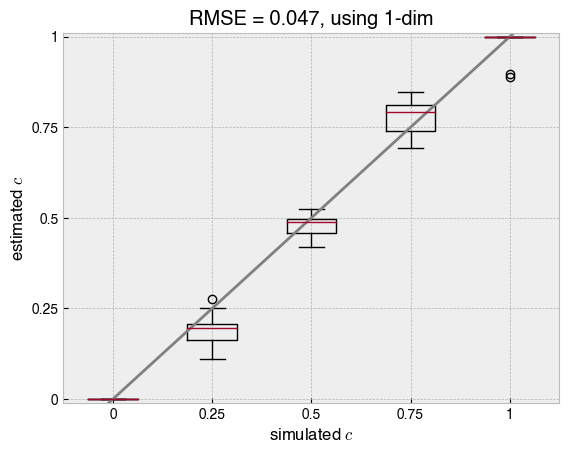

In [269]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = %.3f, joint optim w/ $L^{-1} M L^{-1,T}$'%np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3)); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}, using 1-dim'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('p-value'); plt.axhline(1e-4,color='grey',ls='--'); plt.semilogy(); plt.title('top outlier edge')
# np.sum(estcllmat[:,0]<5e-3)
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

# df = pd.DataFrame(np.random.rand(32,5), columns=[0,0.25,0.5,0.75,1])
# df['E'] = [r'joint optim, RMSE$ = 0.19$']*16+[r'stepwise optim, RMSE$ = 0.04$']*16
# df.iloc[:16,:5] = estcR2mat
# df.iloc[16:,:5] = estcllmat
# sns.violinplot(df.melt(id_vars=['E'], value_vars=[0,0.25,0.5,0.75,1]), cut=0, inner='box',x='variable', y='value', hue='E', palette='Set2'); plt.xlabel(r'simulated $c$'); plt.legend(loc='upper left'); plt.ylabel(r'estimated $c$'); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show()

### Changing the cross-validation scheme to optimize for genetic distance instead of allele frequencies

In [1279]:
# lamb_grid = np.geomspace(1e-2,1e2,10,endpoint=True)[::-1]
## for 5-fold, 10-fold and n-fold: 19s for both 
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=5, factr=1e10, mode='distances')
# mean_cv_err = np.mean(cv_err, axis=0)
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10, mode='distances')
# mean_cv_err10 = np.mean(cv_err, axis=0)
# cv_err = run_cv(sp_graph, lamb_grid, factr=1e10, mode='distances')
# mean_cv_errn = np.mean(cv_err, axis=0)

# plt.plot(lamb_grid, mean_cv_err, '-ko', label='5-fold', alpha=0.3); plt.axvline(lamb_grid[np.argmin(mean_cv_err)], color='orange', ls='--', alpha=0.3)
# plt.plot(lamb_grid, mean_cv_err10, '-ko', label='10-fold', alpha=0.6); plt.axvline(lamb_grid[np.argmin(mean_cv_err10)], color='orange', ls='--', alpha=0.6) 
# plt.plot(lamb_grid, mean_cv_errn, '-ko', label='n-fold', alpha=0.9); plt.axvline(lamb_grid[np.argmin(mean_cv_errn)], color='orange', ls='--', alpha=0.9) 
# plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.legend(); plt.semilogx(); plt.title('On frequencies')

# plt.plot(lamb_grid, mean_cv_err, '-bo', label='5-fold', alpha=0.3); plt.axvline(lamb_grid[np.argmin(mean_cv_err)], color='orange', ls='--', alpha=0.3)
# plt.plot(lamb_grid, mean_cv_err10, '-bo', label='10-fold', alpha=0.6); plt.axvline(lamb_grid[np.argmin(mean_cv_err10)], color='orange', ls='--', alpha=0.6) 
# plt.plot(lamb_grid, mean_cv_errn, '-bo', label='n-fold', alpha=0.9); plt.axvline(lamb_grid[np.argmin(mean_cv_errn)], color='orange', ls='--', alpha=0.9) 
# plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.legend(); plt.semilogx(); plt.title('On distances')

# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

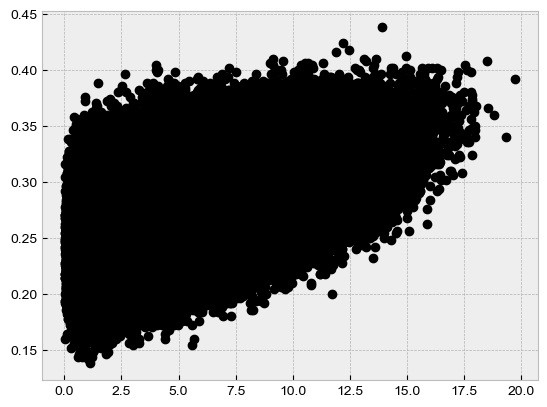

In [101]:
# print(test_ids)
# plt.imshow(fit_cov-fit_cov1); plt.colorbar()
# fit_dist_tr = fit_dist1[np.ix_(train_ids, train_ids)].ravel()
# emp_dist_tr = emp_dist1[np.ix_(train_ids, train_ids)].ravel()
# mu, beta = sp.stats.linregress(fit_dist_tr, emp_dist_tr)[0:2]
# mu, beta = np.polyfit(fit_dist_tr, emp_dist_tr, deg=1)
# from feems.utils import pairwise_PCA_distances

In [493]:
# def comp_fst_mat(genotypes, n_inds, n_demes):
#     """Computes an Fst distance matrix from a sample
#     genotype matrix and set of sub-population ids
#     """
#     n_snps = genotypes.shape[1]
#     acs = np.empty((n_demes, n_snps, 2))
    
#     # compute allele counts
#     for i in range(n_demes):
#         Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
#         acs[i, :, 0] = np.sum(Gi, axis=0)
#         acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
#     # compute Fst matrix
#     Fst = np.empty((n_demes, n_demes))
#     for i in range(n_demes):
#         for j in range(n_demes):
#             Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

#     for i in range(n_demes):
#         Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
#     return(Fst)

# Fst = comp_fst_mat(gen_test_36_adm,20,36)
# acs1 = np.empty((1500,2))
# acs1[:, 0] = np.sum(gen_test_36_adm[np.arange(0,20),:], axis=0)
# acs1[:, 1] = 2*gen_test_36_adm[np.arange(0,20),:].shape[0] - np.sum(gen_test_36_adm[np.arange(0,20),:], axis=0)

# acs2 = np.empty((1500,2))
# acs2[:, 0] = np.sum(gen_test_36_adm[np.arange(20,40),:], axis=0)
# acs2[:, 1] = 2*gen_test_36_adm[np.arange(20,40),:].shape[0] - np.sum(gen_test_36_adm[np.arange(20,40),:], axis=0)

# np.sum(allel.mean_pairwise_difference_between(acs1, acs2))/1500
# allel.average_hudson_fst(acs1, acs2, blen=500)

# plt.hist(np.ravel(Fst))
# plt.imshow(Fst,cmap='RdBu_r'); plt.colorbar()

array([[ 0., 40.],
       [15., 25.],
       [ 2., 38.],
       ...,
       [ 0., 40.],
       [ 4., 36.],
       [ 6., 34.]])